# Random Forest Classification on Campaigns

First, the script imports all necessary packages.

In [1]:
import pandas as pd
import numpy as np
import pymysql as sql
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble import RandomForestClassifier

C:\Users\cramsayer\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


To get the data from MySQL we set up a connection to the database.

In [2]:
host="bootcamp-open.ctzjfvqmre0y.us-east-1.rds.amazonaws.com"
port=3306
dbname="team_2"
user="team_2"
password="captechlistens!"
conn = sql.connect(host, user=user,port=port, passwd=password, db=dbname)

We then read in the data from MySQL and drop all unnecessary columns. We also condition our dataset on only clients we have contacted. Addionally we replace all categorical variables with dummy variables for each category. Output is the dataframe we will be building our random forest model on.

In [3]:
combined = pd.read_sql('select * from combined_table', con=conn)
df = combined.drop(combined[combined["Contacted"] == 0].index)
del df["Contacted"]
del df["Duration"]
del df["Hour"]
del df["Weekday"]
del df["ID"]
del df["Last_Contact"]
del df["Days_Passed"]
del df["Call_Start"]
del df["Current_Success"]
df.head()
df.loc[:,['Education', 'Job']] = df.replace(np.nan, "N/A")
cat_vars = ['Education', 'Job', 'Marital', 'Gender']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    data1=df.join(cat_list)
    df=data1

base_cases = ['Education_N/A', 'Job_N/A', 'Marital_single', 'Gender_M']
to_drop = cat_vars + base_cases
sclient_vars = df.columns.values.tolist()
to_keep = [i for i in sclient_vars if i not in to_drop]
df = df[to_keep]
df.head()

,Age,Balance,HH_Insurance,Car_Loan,Default_Flag,No_Of_Contacts,Total_No_Of_Contacts,Overall_Success,Education_primary,Education_secondary,...,Job_management,Job_retired,Job_self-employed,Job_services,Job_student,Job_technician,Job_unemployed,Marital_divorced,Marital_married,Gender_F
0,32,1218.0,1,0,0,2,2,1,0,0,...,1,0,0,0,0,0,0,0,0,1
1,32,1156.0,1,0,0,5,5,0,1,0,...,0,0,0,0,0,0,0,0,1,1
2,29,637.0,1,0,0,1,2,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,25,373.0,1,0,0,2,2,1,1,0,...,0,0,0,0,1,0,0,0,0,1
4,30,2694.0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,1,1


We then create our random forest model. Important parameters are set to prevent overfitting such as max_features to 8 (# of parameters divided by 3), max_leaf_nodes to 10, and test_size to 0.2. The accuracy of the model is given as output.

In [4]:
X = df.drop(['Overall_Success'], axis=1)
clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10, max_features=8, random_state=222)
train, test = train_test_split(df, test_size = 0.2, random_state=222)
clf=clf.fit(train[X.columns.values], train["Overall_Success"])
predictions = clf.predict(test[X.columns.values])
accuracy_score(test["Overall_Success"], predictions)

0.6354166666666666

We can check the importance of the variables by looking at the feature_importances. The output below shows these importances.

In [5]:
importance = pd.DataFrame(index=np.arange(0, len(X.columns)), columns=['vars', 'ranking'])
importance.vars = X.columns
importance.ranking = clf.feature_importances_
importance

,vars,ranking
0,Age,0.173523
1,Balance,0.239281
2,HH_Insurance,0.291653
3,Car_Loan,0.000000
4,Default_Flag,0.024292
5,No_Of_Contacts,0.040293
6,Total_No_Of_Contacts,0.003212
7,Education_primary,0.000492
8,Education_secondary,0.000510
9,Education_tertiary,0.000000


The function is created to plot confusion matrices which we will use in the next step.

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

We then plot a confusion matrix for our model. As you can see our true positive rate is very high (about 86%) as we correctly identified clients that bought car insurance 1621 times out of the possible 1885. 

Confusion matrix, without normalization
[[ 514  961]
 [ 264 1621]]


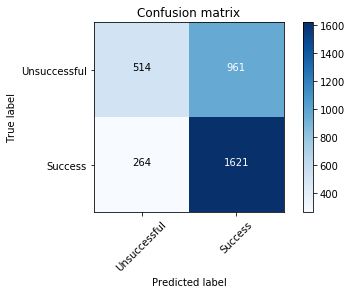

In [7]:
cm = confusion_matrix(test["Overall_Success"], predictions)
plot_confusion_matrix(cm, ["Unsuccessful", 'Success'])

We then create a dataframe that has clients that currently do not have car insurance with the company. These are the clients that the client should potential contact.

In [8]:
clients_to_contact = pd.read_sql('select * from combined_table', con=conn)
clients_to_contact = clients_to_contact.loc[clients_to_contact['Overall_Success'] == 0]
df = clients_to_contact.copy()
df.head()
df.loc[:,['Education', 'Job']] = df.replace(np.nan, "N/A")
cat_vars = ['Education', 'Job', 'Marital', 'Gender']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    data1=df.join(cat_list)
    df=data1

base_cases = ['Education_N/A', 'Job_N/A', 'Marital_single', 'Gender_M']
to_drop = cat_vars + base_cases
sclient_vars = df.columns.values.tolist()
to_keep = [i for i in sclient_vars if i not in to_drop]
df = df[to_keep]
df.head()

,ID,Age,Balance,HH_Insurance,Car_Loan,Default_Flag,Last_Contact,Weekday,Days_Passed,Call_Start,...,Job_management,Job_retired,Job_self-employed,Job_services,Job_student,Job_technician,Job_unemployed,Marital_divorced,Marital_married,Gender_F
1,10001,32,1156.0,1,0,0,2018-08-23,Thursday,6,14:49:03,...,0,0,0,0,0,0,0,0,1,1
4,10004,30,2694.0,0,0,0,2018-06-03,Sunday,87,14:35:44,...,1,0,0,0,0,0,0,0,1,1
5,10005,32,1625.0,0,0,0,2018-05-22,Tuesday,99,14:58:08,...,0,0,0,0,0,1,0,0,0,1
7,10007,35,538.0,1,0,0,2018-05-12,Saturday,109,15:39:43,...,1,0,0,0,0,0,0,1,0,1
8,10008,30,187.0,1,0,0,2017-11-18,Saturday,284,12:20:56,...,0,0,0,0,0,0,0,0,1,1


We then add the probability of a success as a column to this dataframe and sort the dataframe in descending order by this variable. We also format the dataframe to get the output you see below.

In [9]:
clients_to_contact["Prob_Of_Success"] = clf.predict_proba(df[X.columns.values])[:,1]
clients_to_contact["Prob_Of_Success"] = clients_to_contact["Prob_Of_Success"].apply(lambda x: round(x,4))
clients_to_contact=clients_to_contact.sort_values(by=["Prob_Of_Success"], ascending=False)
del clients_to_contact["Duration"]
del clients_to_contact["Hour"]
del clients_to_contact["Weekday"]
del clients_to_contact["Current_Success"]
del clients_to_contact["Last_Contact"]
del clients_to_contact["Call_Start"]
del clients_to_contact["Overall_Success"]
clients_to_contact["Balance"] = clients_to_contact["Balance"].astype(float)
clients_to_contact["Balance"] = clients_to_contact["Balance"].apply(lambda x: round(x,2))
clients_to_contact = clients_to_contact.reset_index(drop=True)
clients_to_contact.head()

,ID,Age,Gender,Marital,Job,Education,Balance,HH_Insurance,Car_Loan,Default_Flag,Days_Passed,No_Of_Contacts,Total_No_Of_Contacts,Contacted,Prob_Of_Success
0,14263,75,M,married,retired,tertiary,4912.0,1,0,0,560,0,5,1,0.7508
1,56892,58,F,married,retired,tertiary,4999.0,1,0,0,-1,0,0,0,0.7490
2,55202,56,F,married,retired,N/A,9708.0,1,0,0,-1,0,0,0,0.7490
3,14463,57,F,married,retired,secondary,3738.0,1,0,0,-1,0,0,0,0.7490
4,59240,58,M,married,retired,tertiary,7697.0,1,0,0,-1,0,0,0,0.7490


Finally we export the dataframe to a csv and close the MySQL connection.

In [10]:
clients_to_contact.to_csv('clients_to_contact.csv', sep = ",")
conn.close()